<a href="https://colab.research.google.com/github/SaahitKar/Option-DeAmericanization/blob/main/Leisen_Reimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import math
from scipy.stats import norm
import time as time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# BBSR

In [6]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return np.maximum(S_t-K,0)
  else:
    return np.maximum(K-S_t,0)

def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def black_scholes(params,is_call):
  S_0,K,T,sigma,r,q = params
  d1 = (np.log(S_0/K)+(r-q+sigma**2/2)*T)/(sigma*math.sqrt(T))
  d2 = d1 - sigma*math.sqrt(T)
  if is_call:
    return(S_0*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2))
  else:
    return(K*math.exp(-r*T)*norm.cdf(-d2) - S_0*math.exp(-q*T)*norm.cdf(-d1))

def backward_induce(V,S,u,pstar,disc,is_call,use_bs,bs_params,is_american):
  # perform one step of backward induction on state vectors V and S
  # Stock Update:
  S = S[:-1]*u

  # Determine Continuing Value
  if use_bs:
    K,delta,sigma,r,q = bs_params
    params = (S,K,delta,sigma,r,q)
    continuing_val = black_scholes(params,is_call)
  else:
    # otherwise use risk-neutral expectation of future prices
    K = bs_params
    continuing_val = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc

  if is_american:
    # Excercise Value (when relevant)
    if is_call:
      exercise_val = np.maximum(S-K,0)
    else:
      exercise_val = np.maximum(K-S,0)
    V = np.maximum(continuing_val,exercise_val)
  else:
    V = continuing_val
  return V, S

def binomial_black_scholes(params,N,is_call,is_american):
  S_0,K,T,sigma,r,q = params
  delta = T/N # time step
  u = math.exp(sigma*math.sqrt(delta)) # CRR Assumptions
  d = 1/u

  pstar = p_riskneutral(r,q,delta,u,d) # risk neutral probability of up
  disc = math.exp(-r*delta) # discount per time step

  i = np.arange(N+1)
  S = S_0*u**(i)*d**(N-i) # initialize stock price range
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity

  # start with Black Scholes prices (instead of payoffs)
  V,S = backward_induce(V,S,u,pstar,disc,is_call,True,(K,delta,sigma,r,q),is_american)

  for i in range(N-1):
    # and N - 1 rounds of typical backward induction
    V,S = backward_induce(V,S,u,pstar,disc,is_call,False,(K),is_american)
  return V[0]

def bbsr(params,N,is_call,is_american):
  if N%2 != 0:
    raise ValueError("N must be even")
  C1 = binomial_black_scholes(params,N//2,is_call,is_american)
  C2 = binomial_black_scholes(params,N,   is_call,is_american)
  return 2*C2 - C1

# Leisen-Reimer


In [7]:
def backward_induce_leisen_reimer(V,S,K,d,p_disc,q_disc,is_call,is_american):
  # Stock Update:
  S = S[:-1]
  S /= d
  # Determine Continuing Value
  continuing_val = p_disc * V[1:] + q_disc * V[:-1]

  if is_american:
    # Excercise Value (when relevant)
    exercise_val = np.maximum(S - K, 0) if is_call else np.maximum(K - S, 0)
    V = np.maximum(continuing_val,exercise_val)
  else:
    V = continuing_val
  return V, S

def peizer_pratt(z,N,mode):
  if N%2==0:
    raise ValueError("N must be odd!")
  if z==0:
    return 0.5 # to avoid zero-division
  numerator = z**2*(N+1/6)
  if mode==1:
    denominator = (N+1/3)**2
  elif mode==2:
    denominator = (N+1/3+0.1/(N+1))**2
  else:
    raise ValueError("Mode must be 1 or 2!")
  return 0.5 + (abs(z)/z) * np.sqrt(0.25-0.25*math.exp(-numerator/denominator))

def leisen_reimer(params,N,is_call,is_american,mode=1):
  S_0,K,T,sigma,r,q = params
  delta = T/N
  disc = math.exp(-r*delta)
  d1 = (np.log(S_0/K)+(r-q+sigma**2/2)*T)/(sigma*math.sqrt(T))
  d2 = d1 - sigma*math.sqrt(T)

  p = peizer_pratt(d2,N,mode)
  p_disc = p*disc
  q_disc = (1-p)*disc
  p_prime = peizer_pratt(d1,N,mode)

  u = math.exp((r-q)*delta) * p_prime/p
  d = (math.exp((r-q)*delta) - p*u)/(1-p)
  log_u = math.log(u)
  log_d = math.log(d)

  i = np.arange(N+1)
  S = S_0 * np.exp(i*log_u + (N-i)*log_d) # initialize stock price range
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity

  for i in range(N):
    V,S = backward_induce_leisen_reimer(V,S,K,d,p_disc,q_disc,is_call,is_american)
  return V[0]

# Comparison

In [8]:
params = (100,100,1,0.20,0.05,0.02)

est_1 = leisen_reimer(params,N=99,is_call=False,is_american=False,mode=1)
est_2 = leisen_reimer(params,N=99,is_call=False,is_american=False,mode=2)
est_3 = bbsr(params,N=100,is_call=False,is_american=False)
exact = black_scholes(params,is_call=False)

print(f"Exact: {exact:.6f}\n")

print(f"BBSR: {est_3:.6f}")
print(f"LR Mode 1: {est_1:.6f}")
print(f"LR Mode 2: {est_2:.6f}\n")

print(f"Error BBSR: {est_3-exact:.6f}")
print(f"Error Mode 1: {est_1-exact:.6f}")
print(f"Error Mode 2: {est_2-exact:.6f}")

Exact: 6.330081

BBSR: 6.330158
LR Mode 1: 6.330119
LR Mode 2: 6.330043

Error BBSR: 0.000078
Error Mode 1: 0.000038
Error Mode 2: -0.000038


## Plotting

In [33]:
params = (100,100,1,0.20,0.05,0.02)
am = True
call = False
max = 500

exact_2 = bbsr(params,N=10000,is_call=call,is_american=am)

Ns_even = np.arange(2,max,2)
Ns_odd = np.arange(1,max,2)

############ BBSR ############
bbsr_runtimes = []
bbsr_errors = []

for N in Ns_even:
  start = time.time()
  est = bbsr(params,N,is_call=call,is_american=am)
  stop = time.time()

  bbsr_runtimes.append(stop-start)
  bbsr_errors.append(est-exact_2)

bbsr_runtimes = np.array(bbsr_runtimes)
bbsr_errors = np.array(bbsr_errors)

############ LR 2 ############
lr_2_runtimes = []
lr_2_errors = []

for N in Ns_odd:
  start = time.time()
  est = leisen_reimer(params,N,is_call=call,is_american=am,mode=2)
  stop = time.time()

  lr_2_runtimes.append(stop-start)
  lr_2_errors.append(est-exact_2)

lr_2_runtimes = np.array(lr_2_runtimes)
lr_2_errors = np.array(lr_2_errors)

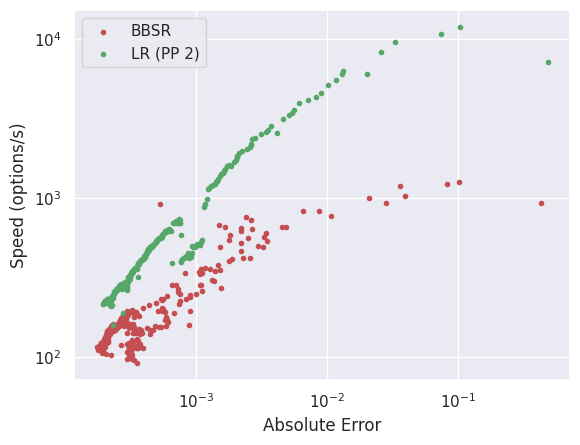

In [34]:
plt.scatter(np.absolute(bbsr_errors),1/bbsr_runtimes,marker='.',color='r',label='BBSR')
plt.scatter(np.absolute(lr_2_errors),1/lr_2_runtimes,marker='.',color='g',label='LR (PP 2)')

plt.legend()
plt.xlabel('Absolute Error')
plt.ylabel('Speed (options/s)')
plt.xscale('log')
plt.yscale('log')
plt.show()

Exact: 6.660689



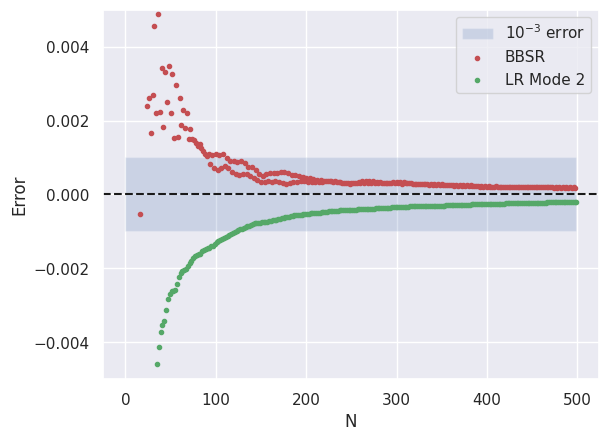

In [35]:
print(f"Exact: {exact_2:.6f}\n")

fig, ax = plt.subplots()
ax.fill_between(np.arange(0,max),-1e-3, 1e-3, alpha=0.2,label='$10^{-3}$ error')

plt.scatter(Ns_even,bbsr_errors,marker='.',color='r',label='BBSR')
plt.scatter(Ns_odd,lr_2_errors,marker='.',color='g',label='LR Mode 2')
plt.axhline(y=0,color='k',linestyle='--')

plt.legend()
plt.xlabel('N')
plt.ylabel('Error')

plt.ylim([-0.005,0.005])
plt.show()

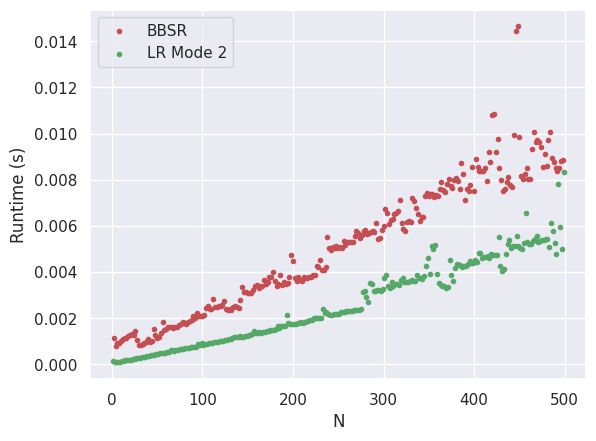

In [32]:
plt.scatter(Ns_even,bbsr_runtimes,marker='.',color='r',label='BBSR')
# plt.scatter(Ns_odd,lr_1_runtimes,marker='.',color='b',label='LR Mode 1')
plt.scatter(Ns_odd,lr_2_runtimes,marker='.',color='g',label='LR Mode 2')

plt.legend()
plt.xlabel('N')
plt.ylabel('Runtime (s)')
plt.show()